# Importance Sampling and AIS

In [77]:
# Autoreload all modules
%load_ext autoreload
%autoreload 2

import numpy as np
import jax
import jax.numpy as jnp
import jax.random as jr
import pylab as plt
from jax.scipy.stats import norm

# add ../mcjax to the path
import sys
sys.path.append('../../')

from mcjax.proba.gaussian import IsotropicGauss
from mcjax.proba.exponential import Exponential
from mcjax.proba.student import Student
from mcjax.IS.IS import IS, AIS

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
# initialize jax RNG
key = jr.key(0)

### Importance Sampling

In [ ]:
# Sample one-dimension standard gaussian distribution
dim = 1
mu = np.zeros(dim)
sigma = 1.
log_var = jnp.log(sigma**2)
target_dist = IsotropicGauss(mu=mu, log_var=log_var)
theta = np.array([4])
gamma = 1.
proposal_dist = Exponential(theta=theta,gamma=gamma)

# Estimate P(X > 4) where X ~ Normal(0,1)
def test(x_batch):
    return jnp.all(x_batch > 4, axis=-1)

In [48]:
importancesampling = IS(logtarget=target_dist)
Sim_size = jnp.arange(1000, 200001, 2000)
keys = jax.random.split(key, len(Sim_size) + 1)
keys, key_ = keys[:-1], keys[-1]
output_arr = [importancesampling.run(key=keys[i],n_samples=Sim_size[i],proposal=proposal_dist,test=test) \
              for i in range(len(Sim_size))]



Text(0.5, 1.0, 'Simulation of P(N(0,1)>4) by Importance Sampling')

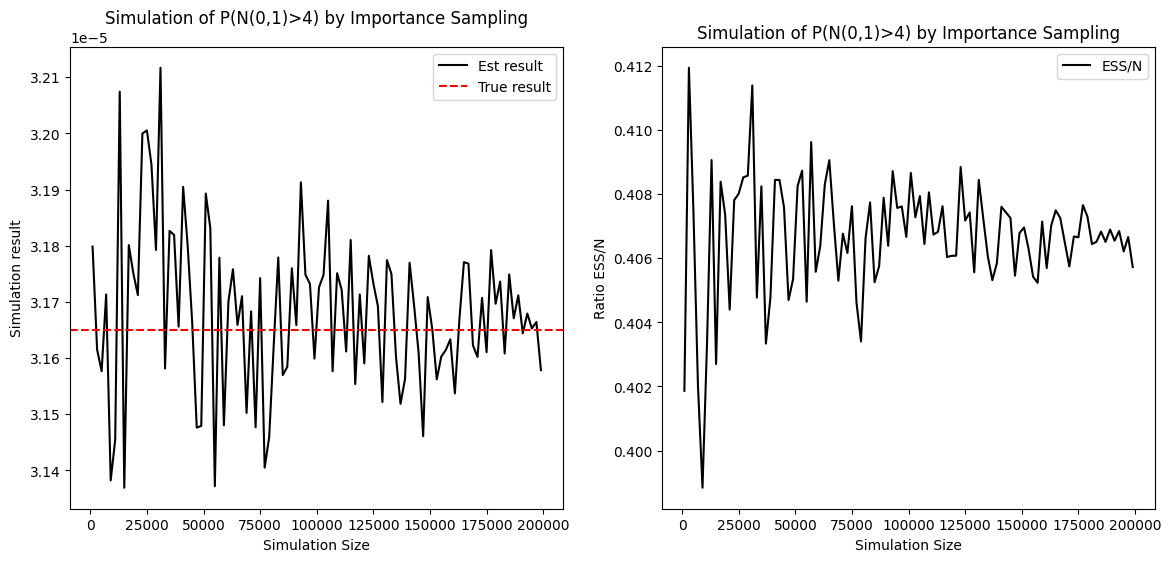

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Estimated Result v.s. True result
estimator_arr = [i["estimator"] for i in output_arr]
axes[0].plot(Sim_size,estimator_arr,color = 'black',label='Est result')
axes[0].axhline(y=1-norm.cdf(4), color='r', linestyle='--', label="True result")
axes[0].legend()
axes[0].set_xlabel("Simulation Size")
axes[0].set_ylabel("Simulation result")
axes[0].set_title("Simulation of P(N(0,1)>4) by Importance Sampling")

# Estimated Sample Size
ess_arr = [i["ess"] for i in output_arr]
essratio_arr = [ess_arr[i]/Sim_size[i] for i in range(len(Sim_size))]
axes[1].plot(Sim_size,essratio_arr,color = 'black',label='ESS/N')
axes[1].legend()
axes[1].set_xlabel("Simulation Size")
axes[1].set_ylabel("Ratio ESS/N")
axes[1].set_title("Simulation of P(N(0,1)>4) by Importance Sampling")

In [25]:
# Sample 1 to 20 dimension standard gaussian distribution 

# Here we estimate P(X > 2) where X ~ Normal(0,1)
def test(x_batch):
    return jnp.all(x_batch > 2, axis=-1)

dim_arr = jnp.arange(1,21,1)
estimator_ratio_arr = []
ess_arr = []
for dim in dim_arr:
    mu = np.zeros(dim)
    sigma = 1.
    log_var = jnp.log(sigma**2)
    target_dist = IsotropicGauss(mu=mu, log_var=log_var)
    theta = np.full(dim, 2.)
    gamma = 1.
    proposal_dist = Exponential(theta=theta,gamma=gamma)
    key, key_ = jr.split(key)
    importancesampling =IS(logtarget=target_dist)
    
    # Fix number of samples = 100000
    n_samples = 100000
    dist_output = importancesampling.run(key=key,n_samples=n_samples, proposal=proposal_dist,test=test)
    true_result = (1-norm.cdf(2))**dim
    estimator_ratio_arr.append(dist_output["estimator"]/true_result)
    ess_arr.append(dist_output["ess"])


Text(0.5, 1.0, 'Simulation of P(N(0,1)>2) by Importance Sampling \n ESS and Dimension')

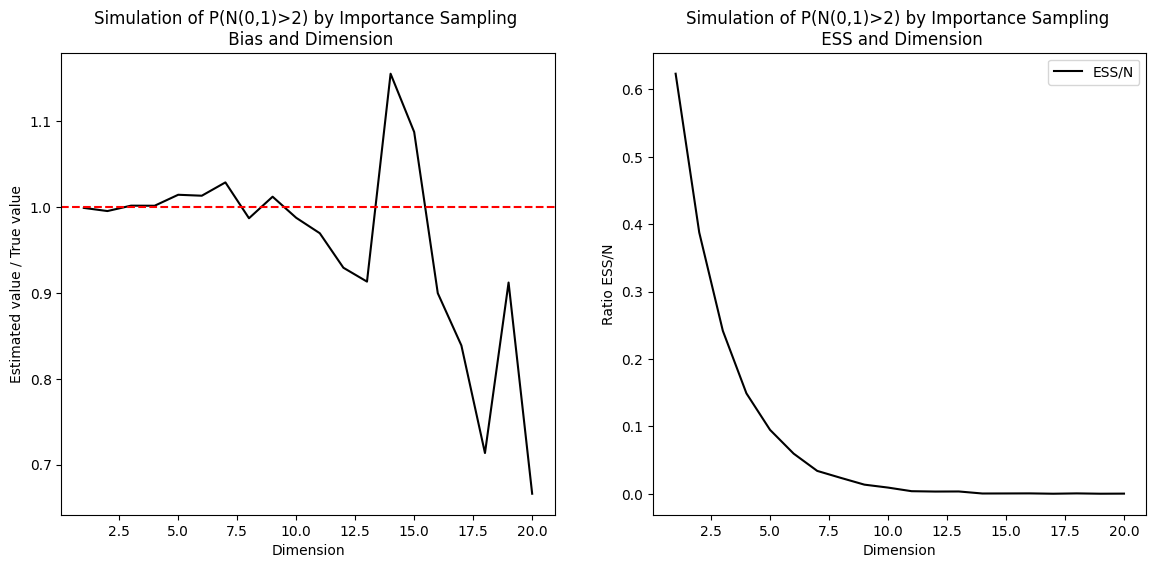

In [27]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

axes[0].plot(dim_arr,estimator_ratio_arr,color = 'black')
axes[0].axhline(y=1, color='r', linestyle='--', label="True result")
axes[0].set_xlabel("Dimension")
axes[0].set_ylabel("Estimated value / True value")
axes[0].set_title("Simulation of P(N(0,1)>2) by Importance Sampling \n Bias and Dimension")

essratio_arr = [ess_arr[i]/n_samples for i in range(len(ess_arr))]
axes[1].plot(dim_arr,essratio_arr,color = 'black',label='ESS/N')
axes[1].legend()
axes[1].set_xlabel("Dimension")
axes[1].set_ylabel("Ratio ESS/N")
axes[1].set_title("Simulation of P(N(0,1)>2) by Importance Sampling \n ESS and Dimension")

### Autonormalized Importance Sampling

In [78]:
# Sample one-dimension standard gaussian distribution
dim = 1
mu = np.zeros(dim)
sigma = 1.
log_var = jnp.log(sigma**2)
target_dist = IsotropicGauss(mu=mu, log_var=log_var)
# theta = np.array([4])
# gamma = 1.
# proposal_dist = Exponential(theta=theta,gamma=gamma)
mu = jnp.full(dim,0.)
cov = jnp.eye(dim)
deg = 2
proposal_dist = Student(mu = mu,cov = cov,deg = deg)


# Estimate P(X > 4) where X ~ Normal(0,1)
def test(x_batch):
    return jnp.all(x_batch > 4, axis=-1)

In [84]:
ais = AIS(logtarget=target_dist)
Sim_size = jnp.arange(1000,100001, 2000)
keys = jax.random.split(key_, len(Sim_size) + 1)
keys, key_ = keys[:-1], keys[-1]
output_arr = [ais.run(key=keys[i],n_samples=Sim_size[i],proposal=proposal_dist,test=test) \
              for i in range(len(Sim_size))]


Text(0.5, 1.0, 'Simulation of P(N(0,1)>4) by AIS')

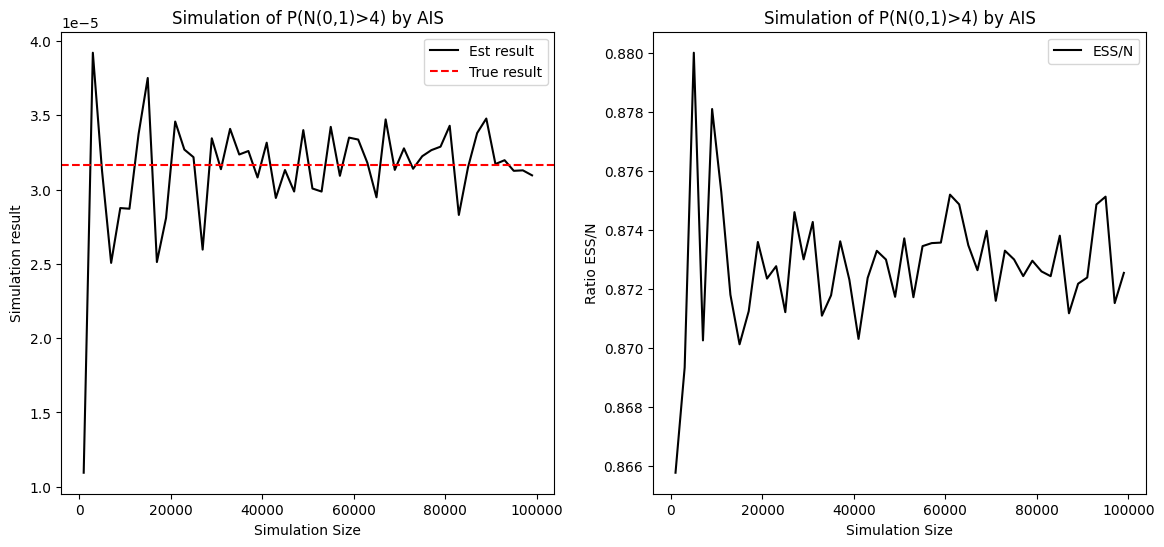

In [87]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Estimated Result v.s. True result
estimator_arr = [i["estimator"] for i in output_arr]
axes[0].plot(Sim_size,estimator_arr,color = 'black',label='Est result')
axes[0].axhline(y=1-norm.cdf(4), color='r', linestyle='--', label="True result")
axes[0].legend()
axes[0].set_xlabel("Simulation Size")
axes[0].set_ylabel("Simulation result")
axes[0].set_title("Simulation of P(N(0,1)>4) by AIS")

# Estimated Sample Size
ess_arr = [i["ess"] for i in output_arr]
essratio_arr = [ess_arr[i]/Sim_size[i] for i in range(len(Sim_size))]
axes[1].plot(Sim_size,essratio_arr,color = 'black',label='ESS/N')
axes[1].legend()
axes[1].set_xlabel("Simulation Size")
axes[1].set_ylabel("Ratio ESS/N")
axes[1].set_title("Simulation of P(N(0,1)>4) by AIS")

In [91]:
# Sample 1 to 20 dimension standard gaussian distribution 

# Here we estimate P(X > 2) where X ~ Normal(0,1)
def test(x_batch):
    return jnp.all(x_batch > 2, axis=-1)

dim_arr = jnp.arange(1,21,1)
estimator_ratio_arr = []
ess_arr = []
for dim in dim_arr:
    mu = np.zeros(dim)
    sigma = 1.
    log_var = jnp.log(sigma**2)
    target_dist = IsotropicGauss(mu=mu, log_var=log_var)
    # theta = np.full(dim, 2.)
    # gamma = 1.
    # proposal_dist = Exponential(theta=theta,gamma=gamma)
    mu = jnp.full(dim,0.)
    cov = jnp.eye(dim)
    deg = 2
    proposal_dist = Student(mu = mu,cov = cov,deg = deg)
    key, key_ = jr.split(key)
    ais =AIS(logtarget=target_dist)
    
    # Fix number of samples = 10000
    n_samples = 10000
    dist_output = ais.run(key=key,n_samples=n_samples, proposal=proposal_dist,test=test)
    true_result = (1-norm.cdf(2))**dim
    estimator_ratio_arr.append(dist_output["estimator"]/true_result)
    ess_arr.append(dist_output["ess"])



Text(0.5, 1.0, 'Simulation of P(N(0,1)>2) by AIS \n ESS and Dimension')

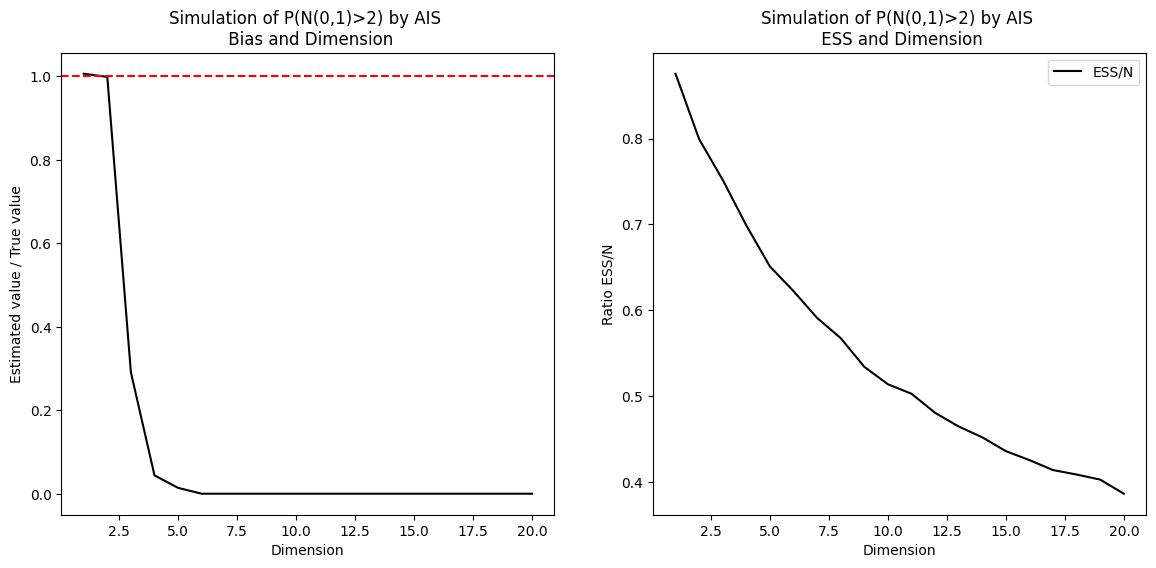

In [93]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

axes[0].plot(dim_arr,estimator_ratio_arr,color = 'black')
axes[0].axhline(y=1, color='r', linestyle='--', label="True result")
axes[0].set_xlabel("Dimension")
axes[0].set_ylabel("Estimated value / True value")
axes[0].set_title("Simulation of P(N(0,1)>2) by AIS \n Bias and Dimension")

essratio_arr = [ess_arr[i]/n_samples for i in range(len(ess_arr))]
axes[1].plot(dim_arr,essratio_arr,color = 'black',label='ESS/N')
axes[1].legend()
axes[1].set_xlabel("Dimension")
axes[1].set_ylabel("Ratio ESS/N")
axes[1].set_title("Simulation of P(N(0,1)>2) by AIS \n ESS and Dimension")